In [1]:
import pandas as pd
import time
import lightgbm as lgb
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
import pyarrow.parquet as pq

import warnings

warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')

In [2]:
# Загружаем файл с первым вариантом обработки данных, агрегация по mean.
file_path = 'data_part_ohe_with_std.parquet'
table = pq.read_table(file_path)
df = table.to_pandas()
print(f"Обработка файла завершена.")

Обработка файла завершена.


In [3]:
# Проверяем датафрейм
df.head(20)

,rn,pre_since_opened,pre_since_confirmed,pre_pterm,pre_fterm,pre_till_pclose,pre_till_fclose,pre_loans_credit_limit,pre_loans_next_pay_summ,pre_loans_outstanding,...,enc_paym_22_3,enc_paym_23_0,enc_paym_23_1,enc_paym_23_2,enc_paym_23_3,enc_paym_24_1,enc_paym_24_2,enc_paym_24_3,enc_paym_24_4,flag
0,-0.227671,-0.203621,-0.168349,-0.228292,-0.179451,0.842199,0.553440,-0.022794,0.511008,-0.161508,...,8,2,0,0,8,0,0,0,10,0
1,0.156628,0.375623,-0.159211,-0.315085,-0.083074,0.585842,-0.322131,-0.273967,-0.186453,-0.120171,...,11,3,0,0,11,3,0,0,11,0
2,-0.900194,-0.163016,0.485552,-0.247278,-0.516773,-0.392724,0.151151,-1.390292,-0.776346,-0.016829,...,2,0,1,0,2,0,0,0,3,0
3,0.252702,-0.395045,-0.225210,-0.133363,-0.111987,-0.354133,-0.053938,0.023172,0.146662,0.368983,...,8,7,0,0,8,5,0,0,10,0
4,-1.092344,0.475065,0.130171,-0.816854,-0.067011,-1.164551,0.624432,0.390902,-1.019243,-0.016829,...,1,0,0,0,1,0,0,0,1,0
5,-0.804120,-0.090507,-0.829359,-0.247278,-0.179451,0.137907,0.032830,0.347809,0.073793,-0.378527,...,3,1,0,0,3,0,0,0,4,0
6,0.540926,-0.008330,-0.047520,0.332845,0.170364,-0.092569,-0.690239,0.228105,-0.169104,0.063549,...,12,6,0,0,12,6,0,0,12,0
7,-0.996269,-0.395045,0.983086,-0.816854,-0.067011,-1.164551,0.624432,-1.074273,1.166830,0.706568,...,2,0,0,0,2,0,0,0,2,0
8,-0.900194,0.301043,-0.580592,0.069153,0.832514,0.700697,0.072270,0.735650,1.652623,0.947700,...,3,0,0,0,3,0,0,0,3,0
9,-1.092344,-0.569067,0.769857,-1.196571,0.382752,-0.392724,-0.322131,0.390902,-0.290552,-0.016829,...,0,1,0,0,0,0,0,0,1,0


In [4]:
df = df.drop('rn', axis=1)

In [5]:
# Разделяем выборку
X = df.drop('flag', axis=1)
y = df['flag']

# Разделение данных на тренировочный и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
rus = RandomUnderSampler()

# Применение уменьшения выборки к данным
X_rus, y_rus = rus.fit_resample(X_train, y_train)
print(X_rus.shape)
print('________________________________')

print(y_rus.shape)
print('________________________________')

print(y_rus.value_counts())
print('________________________________')

(170176, 156)
________________________________
(170176,)
________________________________
flag
0    85088
1    85088
Name: count, dtype: int64
________________________________


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   15.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done 180 out of 180 | elapsed:    5.0s finished


Метрика для случайного леса с использованием RandomUnderSampling: ROC AUC = 0.6616431428714864, Время на постройку: 16.064155101776123
Матрица ошибок для случайного леса с использованием RandomUnderSampling:
[[374043 204603]
 [  6900  14454]]
Метрика для случайного леса с использованием RandomUnderSampling: ROC AUC = 0.6616431428714864, Время на постройку: 16.064155101776123


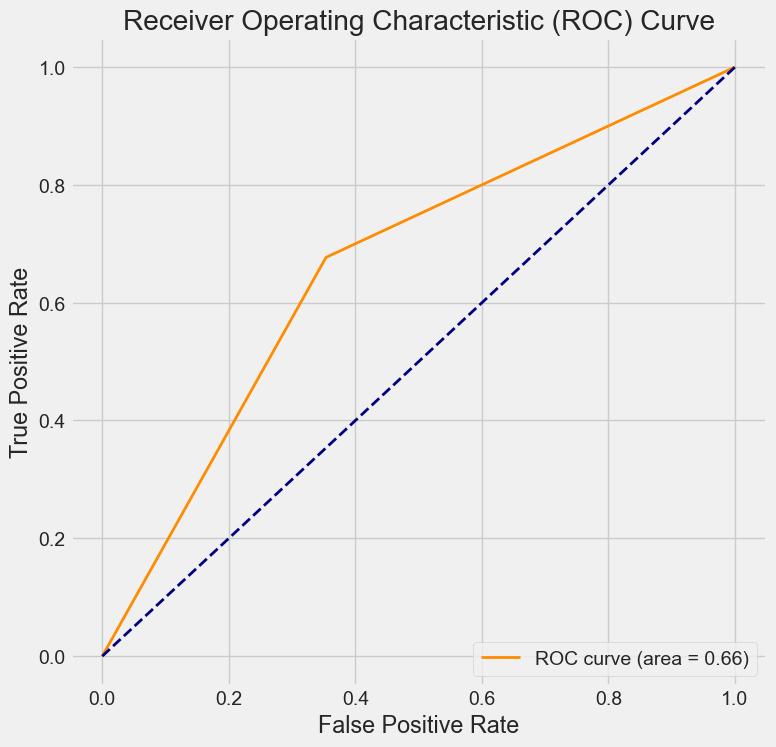

In [8]:
# Создание и обучение модели случайного леса
start_time = time.time()

rf_model_rus = RandomForestClassifier(random_state=42, verbose=1, n_jobs=-1, n_estimators=180, max_depth=30)
rf_model_rus.fit(X_rus, y_rus)

elapsed_time_rf_rus = time.time() - start_time

# Прогнозирование на тестовом наборе
y_pred_rf = rf_model_rus.predict(X_test)

# Рассчитываем ROC AUC
roc_auc_rf_rus = roc_auc_score(y_test, y_pred_rf)

# Вывод результатов
print(f'Метрика для случайного леса с использованием RandomUnderSampling: ROC AUC = {roc_auc_rf_rus}, Время на постройку: {elapsed_time_rf_rus}')

conf_matrix_rf_rus = confusion_matrix(y_test, y_pred_rf)

# ROC-кривая
fpr_rf_rus, tpr_rf_rus, _ = roc_curve(y_test, y_pred_rf)
roc_auc_rf_rus_curve = auc(fpr_rf_rus, tpr_rf_rus)

# Вывод результатов
print(f'Матрица ошибок для случайного леса с использованием RandomUnderSampling:\n{conf_matrix_rf_rus}')
print(f'Метрика для случайного леса с использованием RandomUnderSampling: ROC AUC = {roc_auc_rf_rus}, Время на постройку: {elapsed_time_rf_rus}')

# Визуализация ROC-кривой
plt.figure(figsize=(8, 8))
plt.plot(fpr_rf_rus, tpr_rf_rus, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc_rf_rus_curve))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

Попробуем добавить разнообразие моделей.

In [9]:
start_time = time.time()

knn_model_balanced = KNeighborsClassifier(n_neighbors=6, weights='distance', algorithm='auto') 
knn_model_balanced.fit(X_rus, y_rus)

# Делаем предсказания на тестовом наборе данных
y_pred = knn_model_balanced.predict(X_test)

roc_auc_knn_balanced = roc_auc_score(y_test, y_pred)
print(f'ROC AUC: {roc_auc_knn_balanced}')

# Строим матрицу ошибок
conf_matrix_knn_balanced = confusion_matrix(y_test, y_pred)
print('Матрица ошибок:')
print(conf_matrix_knn_balanced)

end_time = time.time()
elapsed_time_knn_balanced = end_time - start_time
print(f'Время на постройку модели: {elapsed_time_knn_balanced:.2f} секунд')

ROC AUC: 0.60389666590226
Матрица ошибок:
[[382464 196182]
 [  9677  11677]]
Время на постройку модели: 149.74 секунд


GradientBoostingClassifier:
Confusion Matrix:
[[374251 204395]
 [  6945  14409]]

ROC AUC: 0.7197560332419374


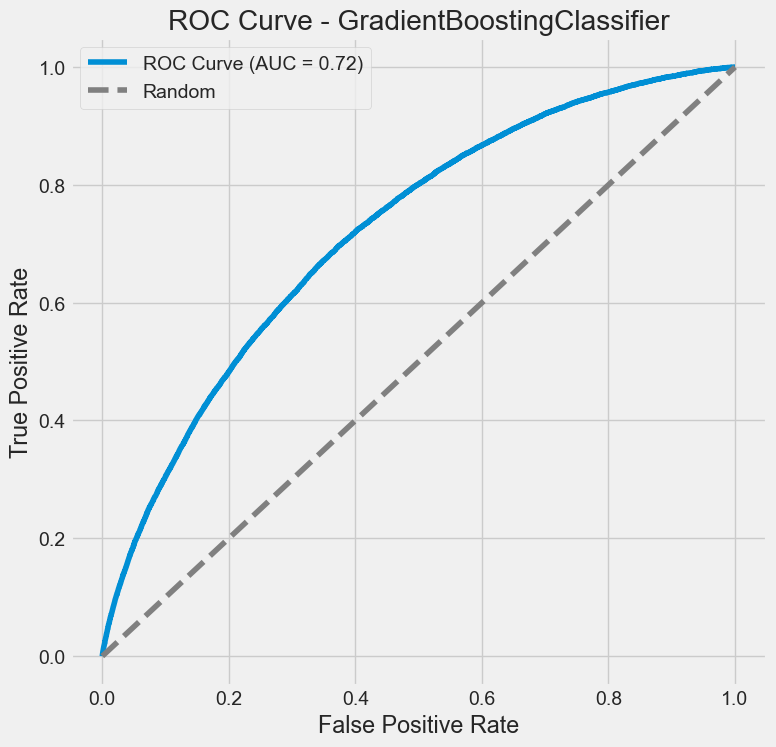

In [10]:
# GradientBoostingClassifier
gb_model = GradientBoostingClassifier(
)
gb_model.fit(X_rus, y_rus)

y_pred_gb = gb_model.predict(X_test)
y_proba_gb = gb_model.predict_proba(X_test)[:, 1]

roc_auc_gb = roc_auc_score(y_test, y_proba_gb)

# Выводим матрицу ошибок и другие метрики
print("GradientBoostingClassifier:")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_gb))
print("\nROC AUC:", roc_auc_gb)

# Рисуем ROC-кривую
fpr_gb, tpr_gb, _ = roc_curve(y_test, y_proba_gb)
plt.figure(figsize=(8, 8))
plt.plot(fpr_gb, tpr_gb, label=f'ROC Curve (AUC = {roc_auc_gb:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.title('ROC Curve - GradientBoostingClassifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.092369
0:	learn: 0.6845671	total: 87.1ms	remaining: 1m 26s
1:	learn: 0.6779015	total: 120ms	remaining: 59.7s
2:	learn: 0.6715299	total: 148ms	remaining: 49.2s
3:	learn: 0.6662895	total: 179ms	remaining: 44.5s
4:	learn: 0.6614278	total: 209ms	remaining: 41.6s
5:	learn: 0.6573342	total: 240ms	remaining: 39.8s
6:	learn: 0.6535314	total: 285ms	remaining: 40.4s
7:	learn: 0.6504807	total: 327ms	remaining: 40.5s
8:	learn: 0.6477758	total: 392ms	remaining: 43.2s
9:	learn: 0.6449867	total: 424ms	remaining: 42s
10:	learn: 0.6427806	total: 458ms	remaining: 41.2s
11:	learn: 0.6407640	total: 490ms	remaining: 40.3s
12:	learn: 0.6390047	total: 517ms	remaining: 39.3s
13:	learn: 0.6373139	total: 545ms	remaining: 38.4s
14:	learn: 0.6358906	total: 574ms	remaining: 37.7s
15:	learn: 0.6345563	total: 596ms	remaining: 36.7s
16:	learn: 0.6331573	total: 621ms	remaining: 35.9s
17:	learn: 0.6319730	total: 644ms	remaining: 35.1s
18:	learn: 0.6309543	total: 670ms	remaining: 34.6s
19:	learn: 

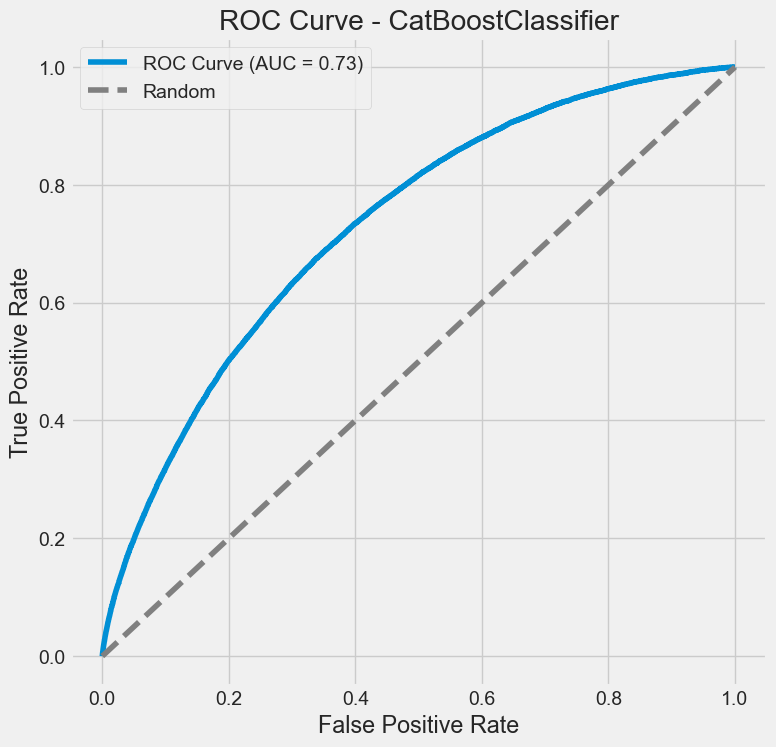

In [11]:
# CatBoostClassifier
cat_model = CatBoostClassifier()
cat_model.fit(X_rus, y_rus, plot=True)
y_proba_cat = cat_model.predict_proba(X_test)[:, 1]
roc_auc_cat = roc_auc_score(y_test, y_proba_cat)
print("\nROC AUC:", roc_auc_cat)

# Рисуем ROC-кривую
fpr_cat, tpr_cat, _ = roc_curve(y_test, y_proba_cat)
plt.figure(figsize=(8, 8))
plt.plot(fpr_cat, tpr_cat, label=f'ROC Curve (AUC = {roc_auc_cat:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.title('ROC Curve - CatBoostClassifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

                             Feature    Importance
31               total_delinquencies  5.938896e+00
25                      is_zero_util  4.369287e+00
50           enc_loans_credit_type_0  3.460965e+00
22                          pre_util  3.388048e+00
8              pre_loans_outstanding  3.213570e+00
..                               ...           ...
37   enc_loans_account_holder_type_5  5.459270e-03
49           enc_loans_account_cur_3  8.068532e-04
34   enc_loans_account_holder_type_2  2.529957e-04
32   enc_loans_account_holder_type_0  2.076036e-07
146                    enc_paym_22_2  0.000000e+00

[156 rows x 2 columns]


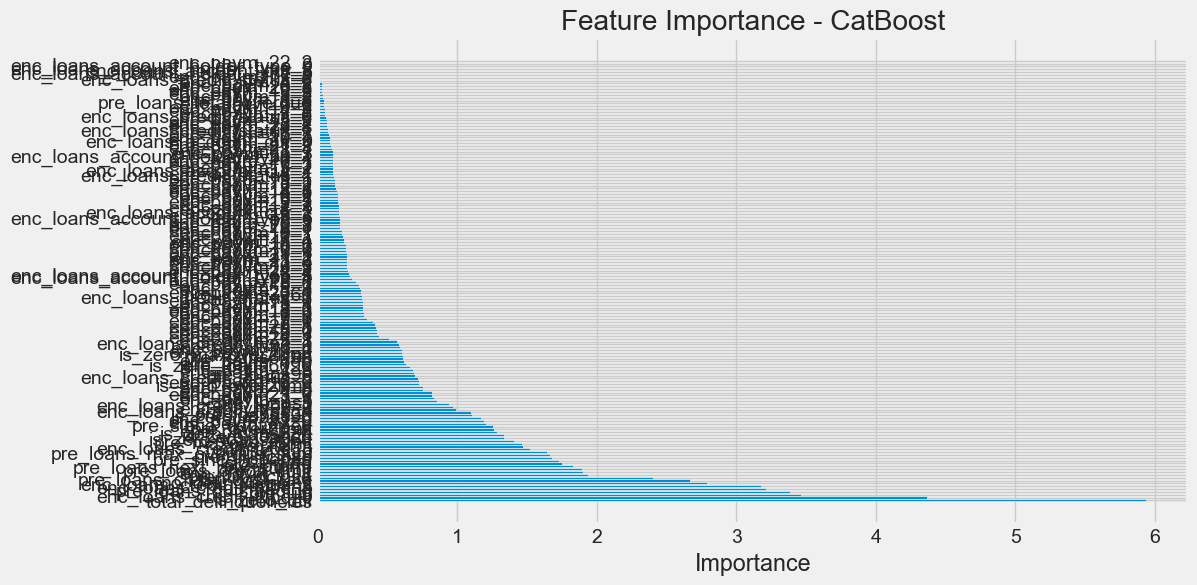

In [12]:
feature_importance = cat_model.feature_importances_
# Создаем DataFrame с именами признаков и их важностями
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})

# Сортируем признаки по важности
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Выводим важности признаков
print(feature_importance_df)

# Рисуем график важности признаков
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance - CatBoost')
plt.show()

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 85088, number of negative: 85088
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020217 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9257
[LightGBM] [Info] Number of data points in the train set: 170176, number of used features: 154
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_

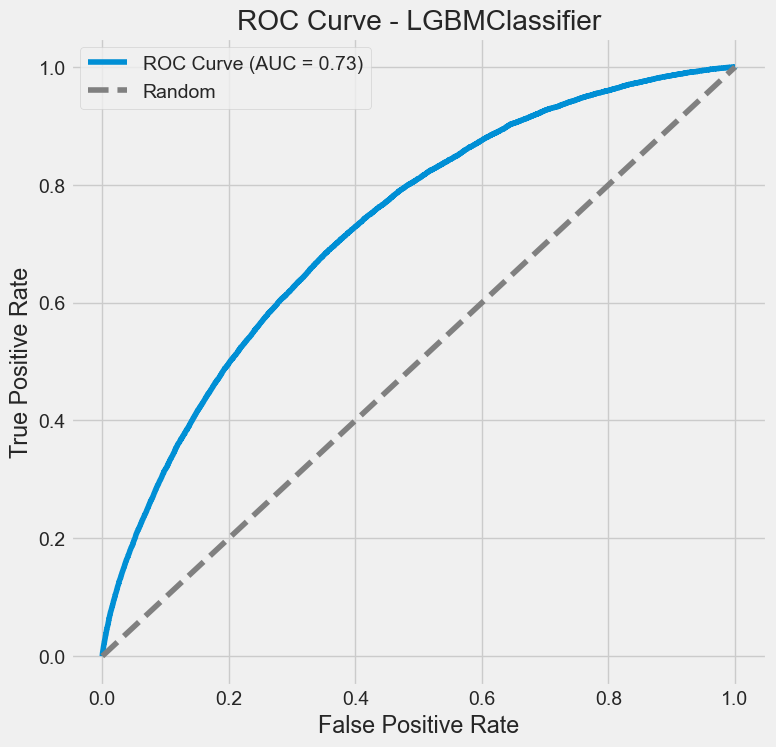

In [13]:
# LGBMClassifier
lgb_model = lgb.LGBMClassifier(max_depth=10)
lgb_model.fit(X_rus, y_rus)

y_pred_lgb = lgb_model.predict(X_test)
y_proba_lgb = lgb_model.predict_proba(X_test)[:, 1]

roc_auc_lgb = roc_auc_score(y_test, y_proba_lgb)

# Выводим матрицу ошибок и другие метрики
print("\nLGBMClassifier:")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_lgb))
print("\nROC AUC:", roc_auc_lgb)

# Рисуем ROC-кривую
fpr_lgb, tpr_lgb, _ = roc_curve(y_test, y_proba_lgb)
plt.figure(figsize=(8, 8))
plt.plot(fpr_lgb, tpr_lgb, label=f'ROC Curve (AUC = {roc_auc_lgb:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.title('ROC Curve - LGBMClassifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [14]:
base_models = [
    ('gradient_boosting', GradientBoostingClassifier(random_state=42, learning_rate=0.1, max_depth=3, n_estimators=1000)),
    ('catboost', CatBoostClassifier(random_state=42, eval_metric='AUC', boosting_type='Ordered', eta=0.02, depth=6, bootstrap_type='Bernoulli', iterations=1500, l2_leaf_reg=4)),
    ('lgbm', lgb.LGBMClassifier(random_state=42, learning_rate=0.1, max_depth=3, n_estimators=1500))
]

# Метамодель
meta_model = CatBoostClassifier()

# Создание модели стекинга
stacking_model = StackingClassifier(estimators=base_models, final_estimator=meta_model)

# Обучение модели стекинга
stacking_model.fit(X_rus, y_rus)

# Получение предсказаний
y_proba_stacking = stacking_model.predict_proba(X_test)[:, 1]

# Оценка производительности
auc_stacking = roc_auc_score(y_test, y_proba_stacking)
print("AUC with Stacking:", auc_stacking)

0:	total: 96.3ms	remaining: 2m 24s
1:	total: 187ms	remaining: 2m 19s
2:	total: 280ms	remaining: 2m 19s
3:	total: 381ms	remaining: 2m 22s
4:	total: 491ms	remaining: 2m 26s
5:	total: 593ms	remaining: 2m 27s
6:	total: 689ms	remaining: 2m 26s
7:	total: 777ms	remaining: 2m 24s
8:	total: 870ms	remaining: 2m 24s
9:	total: 971ms	remaining: 2m 24s
10:	total: 1.06s	remaining: 2m 24s
11:	total: 1.16s	remaining: 2m 23s
12:	total: 1.25s	remaining: 2m 22s
13:	total: 1.35s	remaining: 2m 23s
14:	total: 1.45s	remaining: 2m 23s
15:	total: 1.54s	remaining: 2m 22s
16:	total: 1.63s	remaining: 2m 22s
17:	total: 1.73s	remaining: 2m 22s
18:	total: 1.82s	remaining: 2m 21s
19:	total: 1.91s	remaining: 2m 21s
20:	total: 2.02s	remaining: 2m 22s
21:	total: 2.12s	remaining: 2m 22s
22:	total: 2.2s	remaining: 2m 21s
23:	total: 2.3s	remaining: 2m 21s
24:	total: 2.39s	remaining: 2m 21s
25:	total: 2.48s	remaining: 2m 20s
26:	total: 2.58s	remaining: 2m 20s
27:	total: 2.67s	remaining: 2m 20s
28:	total: 2.76s	remaining: 2m 

Как видим кодирование через one hot в некоторых моделях ухудшило метрику, но в моделях бустинга заметно улучшило его. Попробуем пойти по этому пути и закодировать данные в ohe целиком. Трудность в выборе кодирования объясняется в том, что недостаточно информации о структуре данных, поэтому приходится смотреть все на экспериментах. На мой взгляд, мы можем рассматривать все признаки как категориальные, так как пометка бинаризации говорит о том, что выбраны случайные промежутки чисел